In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# prevent annoying tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 5
warnings.simplefilter("ignore")

## Extracting

In [2]:
df = pd.read_csv('train_data.csv')
df

,images,label
0,salmo.1558.jpg,Salmonella
1,cocci.1866.jpg,Coccidiosis
...,...,...
8065,salmo.1641.jpg,Salmonella
8066,healthy.1145.jpg,Healthy


In [3]:
df.label.value_counts()

Salmonella            2625
Coccidiosis           2476
Healthy               2404
New Castle Disease     562
Name: label, dtype: int64

## Preprocessing

In [4]:
# Imbalanced data

dfc = df.copy()
dfc = dfc.groupby('label', group_keys=False).apply(lambda x: x.sample(562))

dfc

,images,label
5561,cocci.1204.jpg,Coccidiosis
1008,pcrcocci.174.jpg,Coccidiosis
...,...,...
1664,salmo.2123.jpg,Salmonella
2964,pcrsalmo.271.jpg,Salmonella


In [5]:
dfc.label.value_counts()

Coccidiosis           562
Healthy               562
New Castle Disease    562
Salmonella            562
Name: label, dtype: int64

In [6]:
def train_val_test_split(X, y, train_size, val_size, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, train_size=0.9)
    X_test, X_val , y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, train_size =0.5)
    
    train_df = pd.merge(X_train, y_train, right_index = True, left_index = True)
    val_df = pd.merge(X_val, y_val, right_index = True, left_index = True)
    test_df = pd.merge(X_test, y_test, right_index = True, left_index = True)
    
    return train_df, val_df, test_df

train_df, val_df, test_df = train_val_test_split(dfc.images, dfc.label, train_size=0.9, val_size = 0.5, test_size=0.5)
print(f"Train df ({train_df.shape}), test df ({test_df.shape}), val df ({val_df.shape})")

Train df ((2023, 2)), test df ((112, 2)), val df ((113, 2))


In [7]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)

train_gen = train_datagen.flow_from_dataframe(train_df, batch_size=10,shuffle=True,directory='Train', x_col='images',y_col='label', target_size=(150,150),class_mode='categorical')

valid_datagen = ImageDataGenerator()

valid_gen = valid_datagen.flow_from_dataframe(val_df, batch_size=10,shuffle=True,directory='Train', x_col='images', y_col='label',target_size=(150,150), class_mode='categorical')

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_gen=valid_datagen.flow_from_dataframe(test_df, directory='Train', x_col='images', y_col='label', target_size=(150,150),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 2023 validated image filenames belonging to 4 classes.
Found 113 validated image filenames belonging to 4 classes.
Found 112 validated image filenames belonging to 4 classes.


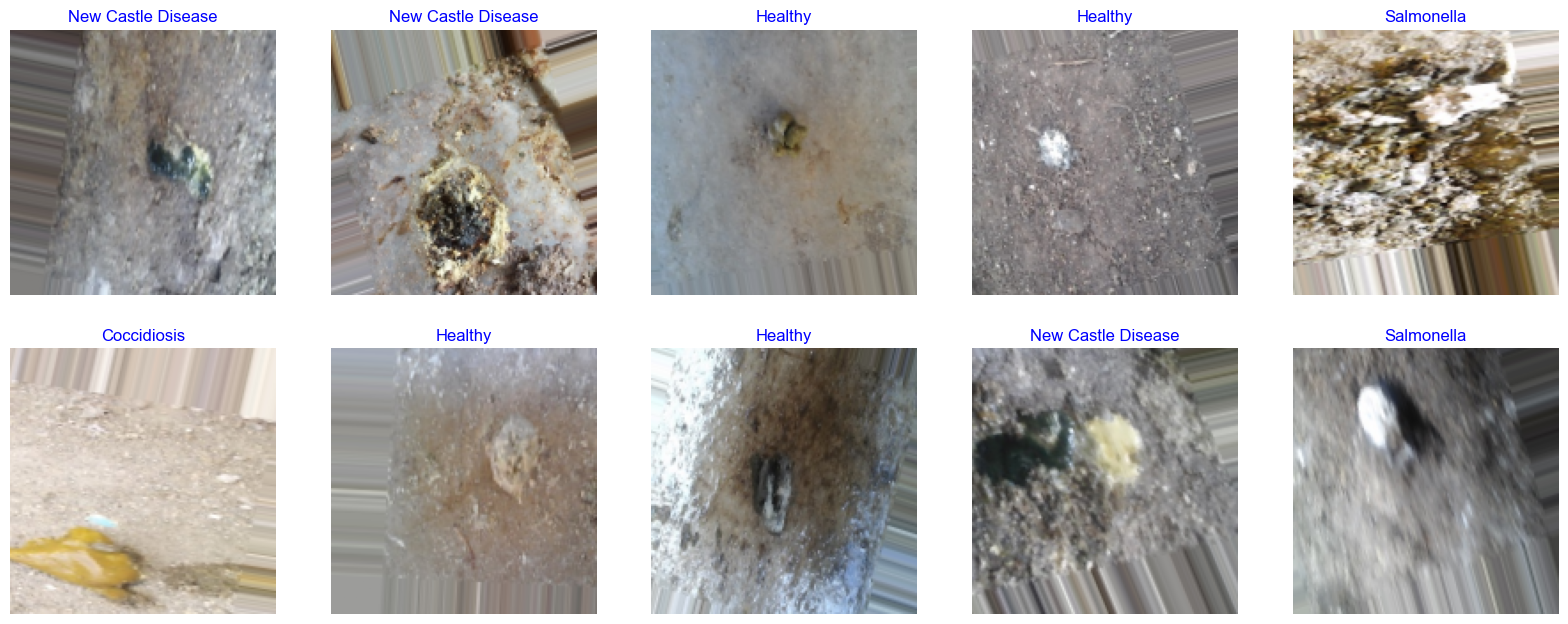

In [8]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i]/255     
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

## Model

In [9]:
#Callbacks

# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs = {}):
#         if(logs.get('val_acc') > 0.98):
#             print("\nLoss is low so cancelling training!")
#             self.model.stop_training = True
                       


class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_acc') is not None and logs.get('val_acc') > 0.99:                 
                print("\nReached 99% accuracy so cancelling training!")
                
                # Stop training once the above condition is met
                self.model.stop_training = True
                
callbacks = myCallback()

In [10]:
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [11]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=(150,150,3), pooling='max') 
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(4, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

In [12]:
# model = create_model12345()


history=model.fit(x=train_gen,  epochs=100, verbose=1,  validation_data=valid_gen, callbacks=[callbacks])

Epoch 1/100
203/203 [==============================] - 81s 300ms/step - loss: 21.9735 - accuracy: 0.7113 - val_loss: 17.5538 - val_accuracy: 0.7699
Epoch 2/100
203/203 [==============================] - 44s 216ms/step - loss: 13.9033 - accuracy: 0.8112 - val_loss: 11.3605 - val_accuracy: 0.9204
Epoch 3/100
203/203 [==============================] - 43s 213ms/step - loss: 9.0276 - accuracy: 0.8631 - val_loss: 7.1489 - val_accuracy: 0.9115
Epoch 4/100
203/203 [==============================] - 43s 214ms/step - loss: 6.0375 - accuracy: 0.8784 - val_loss: 4.7690 - val_accuracy: 0.9646
Epoch 5/100
203/203 [==============================] - 44s 216ms/step - loss: 4.0569 - accuracy: 0.9016 - val_loss: 3.2132 - val_accuracy: 0.9469
Epoch 6/100
203/203 [==============================] - 45s 219ms/step - loss: 2.8057 - accuracy: 0.8992 - val_loss: 2.2412 - val_accuracy: 0.9292
Epoch 7/100
203/203 [==============================] - 44s 215ms/step - loss: 1.9168 - accuracy: 0.9170 - val_loss: 1.51

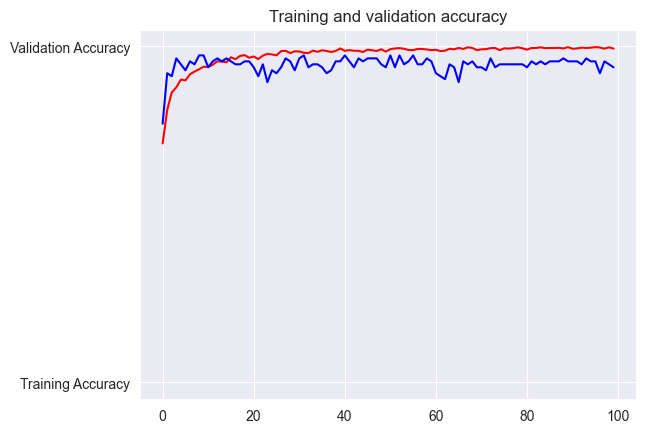

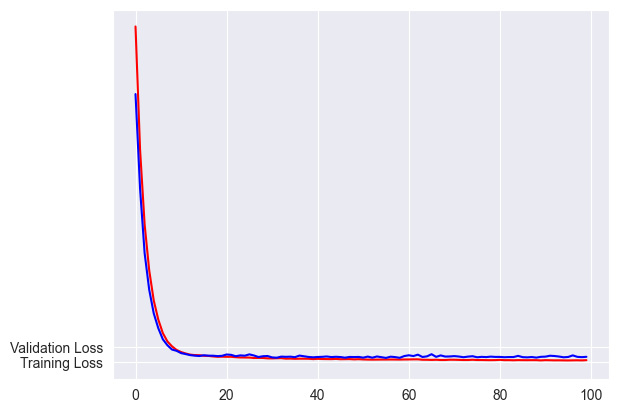

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

2/2 [==============================] - 4s 689ms/step
there were 4 in 112 tests for an accuracy of  96.43


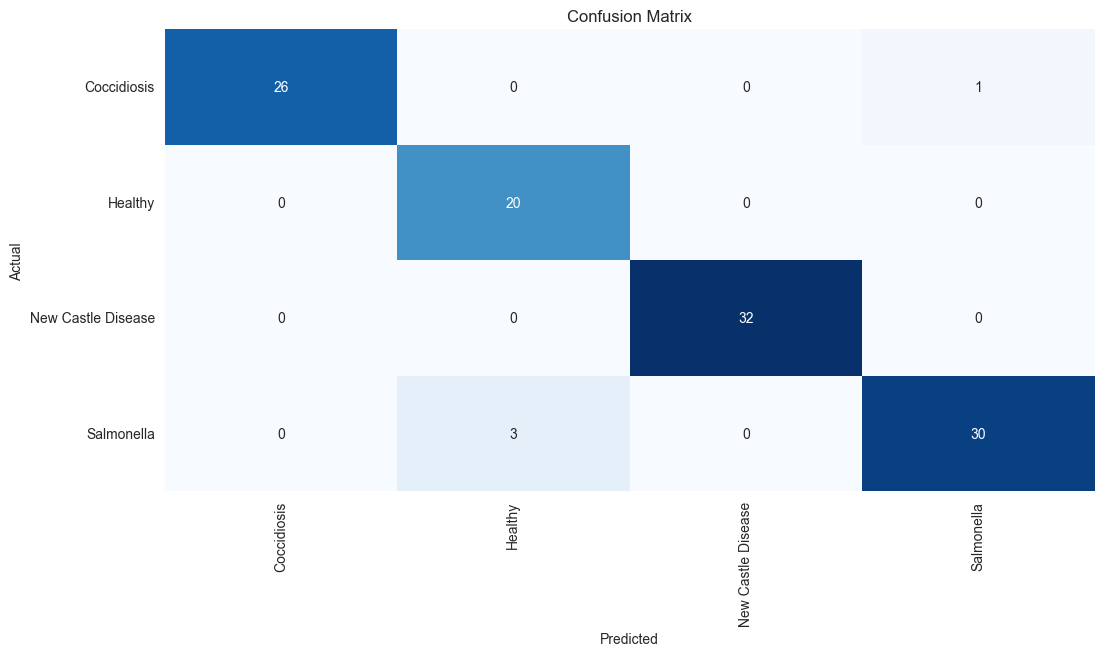

Classification Report:
----------------------
                     precision    recall  f1-score   support

       Coccidiosis     1.0000    0.9630    0.9811        27
           Healthy     0.8696    1.0000    0.9302        20
New Castle Disease     1.0000    1.0000    1.0000        32
        Salmonella     0.9677    0.9091    0.9375        33

          accuracy                         0.9643       112
         macro avg     0.9593    0.9680    0.9622       112
      weighted avg     0.9672    0.9643    0.9646       112



In [14]:
classes=list(train_gen.class_indices.keys())
class_count=len(classes)


y_pred= []
y_true=test_gen.labels
errors=0
preds=model.predict(test_gen, steps = test_steps ,verbose=1) # predict on the test set
tests=len(preds)
for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
        y_pred.append(pred_index)
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')
ypred=np.array(y_pred)
ytrue=np.array(y_true)
cm = confusion_matrix(ytrue, ypred )
# plot the confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

## Predict Satuan

In [15]:
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

def classify(img_path):
    class_names=list(train_gen.class_indices.keys())
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    predict = model.predict(img_preprocessed)
    score = tf.nn.softmax(predict[0])
    
    print(score)
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)

classify("Orange-Poos.jpg")

tf.Tensor([0.4744463  0.17523506 0.1751603  0.17515829], shape=(4,), dtype=float32)
This image most likely belongs to Coccidiosis with a 47.44 percent confidence.


In [16]:
subject='chickens' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
# model_save_loc=os.path.join(working_dir, save_id)
model.save(save_id)
print ('model was saved as ' , save_id )

model was saved as  chickens_96.42.h5
